In [3]:
import torch
import os
import random
import datetime
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset

Image 1: US07319104-20080115-C00398.png - Image 2: US07319104-20080115-C00398.png
Image 1: US07319104-20080115-C00150.png - Image 2: US07319104-20080115-C00150.png
Image 1: US07323608-20080129-C00068.png - Image 2: US07323608-20080129-C00068.png
Image 1: US07314887-20080101-C00232.png - Image 2: US07314887-20080101-C00232.png
Image 1: US07321045-20080122-C00101.png - Image 2: US07321045-20080122-C00101.png
Image 1: US07319111-20080115-C00160.png - Image 2: US07319111-20080115-C00160.png
Image 1: US07320977-20080122-C00117.png - Image 2: US07320977-20080122-C00117.png
Image 1: US07320972-20080122-C00094.png - Image 2: US07320972-20080122-C00094.png
Image 1: US07314937-20080101-C00147.png - Image 2: US07314937-20080101-C00147.png
Image 1: US07317022-20080108-C00047.png - Image 2: US07317022-20080108-C00047.png


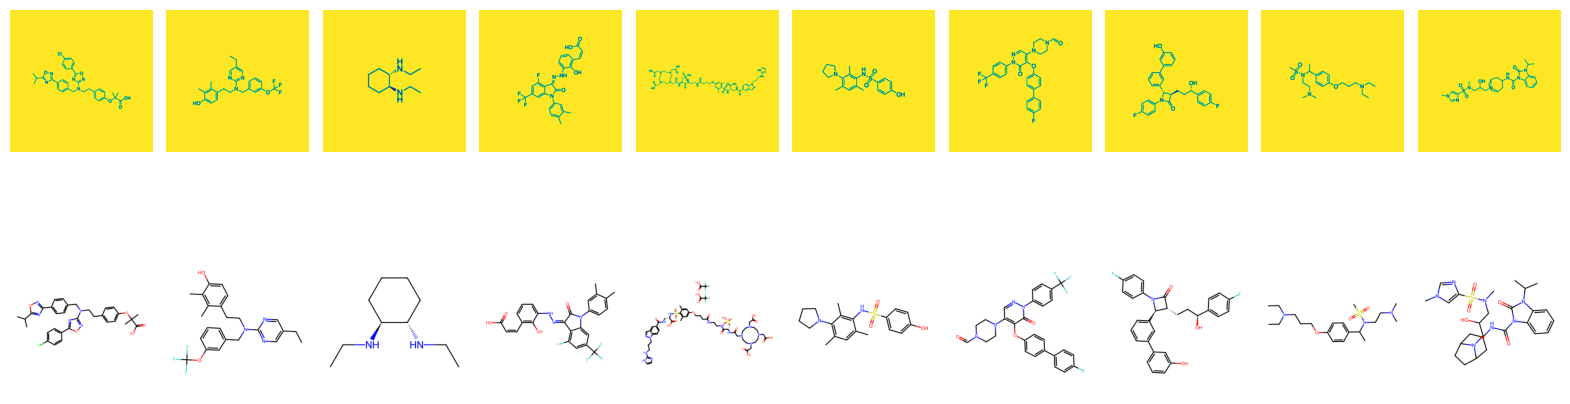

In [4]:
def check_matching_image_counts(root_dir1, root_dir2):
    num_images_dir1 = len(os.listdir(root_dir1))
    num_images_dir2 = len(os.listdir(root_dir2))
    
    return num_images_dir1 == num_images_dir2

def get_matching_indices(root_dir1, root_dir2):
    indices = []
    
    num_images_dir1 = len(os.listdir(root_dir1))
    num_images_dir2 = len(os.listdir(root_dir2))
    
    min_num_images = min(num_images_dir1, num_images_dir2)
    
    for i in range(min_num_images):
        indices.append(i)
        
    return indices

def plot_random_images(root_dir1, root_dir2, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    # Check if the number of images in each directory matches
    matching_counts = check_matching_image_counts(root_dir1, root_dir2)
    if not matching_counts:
        print("Error: Number of images in each directory does not match.")
        return
    
    # Get matching indices for images from each directory
    indices = get_matching_indices(root_dir1, root_dir2)
    
    # Get random subset of indices
    selected_indices = random.sample(indices, min(num_images, len(indices)))
    
    # Lists to store image names
    img_names1 = []
    img_names2 = []
    
    # Plot images from both directories with the same indices
    for i, idx in enumerate(selected_indices):
        img_name = os.listdir(root_dir1)[idx]
        img_names1.append(img_name)
        img_names2.append(img_name)
        
        img_path_dir1 = os.path.join(root_dir1, img_name)
        img_path_dir2 = os.path.join(root_dir2, img_name)
        
        img_dir1 = Image.open(img_path_dir1)
        img_dir2 = Image.open(img_path_dir2)
        
        axes[0, i].imshow(img_dir1)
        axes[0, i].axis('off')
        
        axes[1, i].imshow(img_dir2)
        axes[1, i].axis('off')
    
    # Print paired image names
    for name1, name2 in zip(img_names1, img_names2):
        print(f"Image 1: {name1} - Image 2: {name2}")
    
    plt.show()

# 경로 설정
root_dir1 = 'data/train/chemdraw_train'
root_dir2 = 'data/train/chemdraw_train_smlies'

# 이미지 플로팅
plot_random_images(root_dir1, root_dir2)


In [5]:
class ImagePairDataset(Dataset):
    def __init__(self, root_dir1, root_dir2, label, transform=None):
        self.root_dir1 = root_dir1
        self.root_dir2 = root_dir2
        self.label = label
        self.transform = transform
        self.samples = []
        
        # 두 디렉토리 안의 이미지 파일을 쌍으로 찾기
        for filename in os.listdir(root_dir1):
            img1_path = os.path.join(root_dir1, filename)
            img2_path = os.path.join(root_dir2, filename)
            if os.path.isfile(img1_path) and os.path.isfile(img2_path):
                # 올바른 쌍인 경우 레이블을 설정
                self.samples.append((img1_path, img2_path, self.label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img1_path, img2_path, label = self.samples[idx]
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, label

In [6]:
class CombinedImagePairDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.total_length = len(dataset1) + len(dataset2)

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        if idx < len(self.dataset1):
            img1, img2, label = self.dataset1[idx]
            return img1, img2, label
        else:
            # Adjust the index to fit within the second dataset
            adjusted_idx = idx - len(self.dataset1)
            img1, img2, label = self.dataset2[adjusted_idx]
            return img1, img2, label

In [7]:
class ImageComparisonModel(nn.Module):
    def __init__(self):
        super(ImageComparisonModel, self).__init__()
        
        # Stream 1 for the first image modality
        self.stream1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Stream 2 for the second image modality
        self.stream2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fusion and decision mechanism
        self.comparison = nn.Sequential(
            nn.Linear(32*32*128*2, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1)  # Binary classification
        )
        
    def forward(self, x1, x2):
        x1 = self.stream1(x1)
        x2 = self.stream2(x2)
        
        # Flatten the features from both streams
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        
        # Concatenate the features
        x = torch.cat((x1, x2), dim=1)
        
        # Pass through the comparison mechanism
        x = self.comparison(x)
        return x

In [8]:
# # 모델 초기화
combined_model = ImageComparisonModel()

print(combined_model)

ImageComparisonModel(
  (stream1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stream2): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fusion): Sequential(
    (0): Linear(in_features=262144, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear

In [9]:
# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 이미지 크기를 64x64로 조정
    transforms.ToTensor(),         # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])

In [10]:
batch_size = 8

In [11]:
# 경로 설정

chemdraw_train = "data/train/chemdraw_train"
chemdraw_test = "data/test/chemdraw_test"
chemdraw_valid = "data/valid/chemdraw_val"

chemdraw_train_smlies = "data/train/chemdraw_train_smlies"
chemdraw_test_smlies = "data/test/chemdraw_test_smlies"
chemdraw_valid_smlies = "data/valid/chemdraw_val_smlies"

chemdraw_train_smlies_wrong = "data/train/chemdraw_train_smlies_wrong"
chemdraw_test_smlies_wrong = "data/test/chemdraw_test_smlies_wrong"
chemdraw_valid_smlies_wrong = "data/valid/chemdraw_val_smlies_wrong"

In [12]:
# 학습 데이터셋 생성
combine_train_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_train, chemdraw_train_smlies, 1, transform=transform),
                                                 ImagePairDataset(chemdraw_train, chemdraw_train_smlies_wrong, 0, transform=transform))
combine_test_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_test, chemdraw_test_smlies, 1, transform=transform),
                                                ImagePairDataset(chemdraw_test, chemdraw_test_smlies_wrong, 0, transform=transform))
combine_valid_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_valid, chemdraw_valid_smlies, 1, transform=transform),
                                                 ImagePairDataset(chemdraw_valid, chemdraw_valid_smlies_wrong, 0, transform=transform))

# 데이터로더 생성
train_loader = DataLoader(combine_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(combine_test_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(combine_valid_dataset, batch_size=batch_size, shuffle=True)

In [13]:
print(combine_train_dataset.dataset1.root_dir1)
print(combine_train_dataset.dataset1.root_dir2)

print(combine_test_dataset.dataset1.root_dir1)
print(combine_test_dataset.dataset1.root_dir2)

print(combine_valid_dataset.dataset1.root_dir1)
print(combine_valid_dataset.dataset1.root_dir2)

data/train/chemdraw_train
data/train/chemdraw_train_smlies
data/test/chemdraw_test
data/test/chemdraw_test_smlies
data/valid/chemdraw_val
data/valid/chemdraw_val_smlies


In [14]:
print(train_loader.dataset.dataset1.samples)

[('data/train/chemdraw_train/US07314934-20080101-C00105.png', 'data/train/chemdraw_train_smlies/US07314934-20080101-C00105.png', 1), ('data/train/chemdraw_train/US07314871-20080101-C00057.png', 'data/train/chemdraw_train_smlies/US07314871-20080101-C00057.png', 1), ('data/train/chemdraw_train/US07314934-20080101-C00148.png', 'data/train/chemdraw_train_smlies/US07314934-20080101-C00148.png', 1), ('data/train/chemdraw_train/US07317125-20080108-C00074.png', 'data/train/chemdraw_train_smlies/US07317125-20080108-C00074.png', 1), ('data/train/chemdraw_train/US07314883-20080101-C00533.png', 'data/train/chemdraw_train_smlies/US07314883-20080101-C00533.png', 1), ('data/train/chemdraw_train/US07314934-20080101-C00127.png', 'data/train/chemdraw_train_smlies/US07314934-20080101-C00127.png', 1), ('data/train/chemdraw_train/US07314934-20080101-C00163.png', 'data/train/chemdraw_train_smlies/US07314934-20080101-C00163.png', 1), ('data/train/chemdraw_train/US07317012-20080108-C00028.png', 'data/train/ch

In [15]:
print(train_loader.dataset.dataset2.samples)

[('data/train/chemdraw_train/US07314934-20080101-C00105.png', 'data/train/chemdraw_train_smlies_wrong/US07314934-20080101-C00105.png', 0), ('data/train/chemdraw_train/US07314871-20080101-C00057.png', 'data/train/chemdraw_train_smlies_wrong/US07314871-20080101-C00057.png', 0), ('data/train/chemdraw_train/US07314934-20080101-C00148.png', 'data/train/chemdraw_train_smlies_wrong/US07314934-20080101-C00148.png', 0), ('data/train/chemdraw_train/US07317125-20080108-C00074.png', 'data/train/chemdraw_train_smlies_wrong/US07317125-20080108-C00074.png', 0), ('data/train/chemdraw_train/US07314883-20080101-C00533.png', 'data/train/chemdraw_train_smlies_wrong/US07314883-20080101-C00533.png', 0), ('data/train/chemdraw_train/US07314934-20080101-C00127.png', 'data/train/chemdraw_train_smlies_wrong/US07314934-20080101-C00127.png', 0), ('data/train/chemdraw_train/US07314934-20080101-C00163.png', 'data/train/chemdraw_train_smlies_wrong/US07314934-20080101-C00163.png', 0), ('data/train/chemdraw_train/US073

In [16]:
print(train_loader.dataset.total_length)

7284


In [17]:
# GPU를 사용할 수 있는지 확인합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = combined_model.to(device)

print(device)

cuda


In [18]:
# 학습을 위한 하이퍼파라미터 설정
learning_rate = 0.001
num_epochs = 30

# 손실 함수 정의
criterion = nn.BCEWithLogitsLoss()

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(criterion)

BCEWithLogitsLoss()


In [19]:
save_model_path = "Check_Model"

def save_model(model, save_path):
    # 새로운 폴더 생성 (없으면)
    os.makedirs(save_path, exist_ok=True)
    # 현재 시간 가져오기
    now = datetime.datetime.now()
    # 모델 저장
    torch.save(model.state_dict(), os.path.join(save_path, f"model_{now.strftime('%Y%m%d_%H%M%S')}.pth"))

def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, save_path):
    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        
        # 훈련 데이터로 모델 학습
        for inputs1, inputs2, labels in train_loader:
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs1.size(0)
        
        # 평균 훈련 손실 계산
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        running_valid_loss = 0.0
        correct = 0
        total = 0
        
        # 검증 데이터로 모델 평가
        for inputs1, inputs2, labels in valid_loader:
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, labels.float().view(-1, 1))
            running_valid_loss += loss.item() * inputs1.size(0)
            
            # 정확도 계산
            predicted = torch.round(torch.sigmoid(outputs))
            correct += (predicted == labels.view(-1, 1)).sum().item()
            total += labels.size(0)
        
        # 평균 검증 손실 계산
        epoch_valid_loss = running_valid_loss / len(valid_loader.dataset)
        valid_losses.append(epoch_valid_loss)
        
        # 정확도 계산
        accuracy = correct / total
        
        # 에포크마다 학습 결과 출력
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.8f}, Valid Loss: {epoch_valid_loss:.8f}, Accuracy: {accuracy:.8f}')
        
        # 더 나은 모델인 경우 저장
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            if save_path:
                save_model(model, save_path)
        
        # 모델의 손실이 더 낮아졌을 때 저장
        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            if save_path:
                save_model(model, save_path)

    print("모델이 저장되었습니다.")
    return train_losses, valid_losses, best_accuracy

In [ ]:
# 모델 학습
train_losses, valid_losses = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, save_model_path)

Epoch 1/30, Train Loss: 0.71474655, Valid Loss: 0.69393432, Accuracy: 0.50000000
Epoch 2/30, Train Loss: 0.69340871, Valid Loss: 0.69341419, Accuracy: 0.50000000
Epoch 3/30, Train Loss: 0.69334553, Valid Loss: 0.69314815, Accuracy: 0.50000000
Epoch 4/30, Train Loss: 0.69329115, Valid Loss: 0.69316005, Accuracy: 0.50000000


In [ ]:
# 학습 결과 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
num_epochs_improve = 5

# 모델 개선 함수
def improve_model(model, optimizer, criterion, train_loader, valid_loader, num_epochs):
    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_valid_loss += loss.item() * inputs.size(0)
            epoch_valid_loss = running_valid_loss / len(valid_loader.dataset)
            valid_losses.append(epoch_valid_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}')

    torch.save(model.state_dict(), 'improved_model.pth')
    print("모델이 저장되었습니다.")
    return train_losses, valid_losses

In [ ]:
# 모델 개선 및 재학습
improved_train_losses, improved_valid_losses = improve_model(model, optimizer, criterion, train_loader, valid_loader, num_epochs_improve)

In [ ]:
def evaluate_model(model, criterion, test_loader):
    total_samples = 0
    total_loss = 0
    correct_predictions = 0
    
    with torch.no_grad():
        for inputs1, inputs2 in test_loader:
            inputs1, inputs2 = inputs1.to(device), inputs2.to(device)
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, torch.ones(outputs.shape[0], 1, device=device))  # 이진 분류 문제에서는 일관된 레이블 사용
            total_loss += loss.item() * inputs1.size(0)
            
            # 모델의 예측 결과를 확인하여 정확도 계산
            predicted_labels = torch.round(torch.sigmoid(outputs))
            correct_predictions += (predicted_labels == 1).sum().item()
            
            total_samples += inputs1.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples * 100
    
    return avg_loss, accuracy


In [ ]:
# 테스트 데이터셋에 대해 모델 평가
test_loss, test_accuracy = evaluate_model(model, criterion, test_loader)
print(f'Test Loss: {test_loss:.8f}, Test Accuracy: {test_accuracy:.2f}%')